In [1]:
import numpy as np
import pandas as pd
import json
import h5py
import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import csv
from keras.callbacks import ModelCheckpoint
from random import randint

from sklearn.model_selection import train_test_split

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import re

from DataGenerator import DataGenerator
from livelossplot import PlotLossesKeras

import tensorflow as tf
#from classifiers import inception

from matplotlib.colors import ListedColormap

Using TensorFlow backend.


In [2]:
data_path = 'data_tord_may2020'
full_data_csv = 'balanced_csv_3_class.csv'
csv_root = 'csv_folder_3_class'
balanced = True
if balanced:
    root_sub = 'balanced'
else:
    root_sub = 'raw'
train_csv = f'{csv_root}/{root_sub}/train_set.csv'
val_csv = f'{csv_root}/{root_sub}/validation_set.csv'
test_csv = f'{csv_root}/{root_sub}/test_set.csv'

data_gen = DataGenerator(csv_root, train_csv, val_csv, test_csv)

In [3]:
full_ds = data_gen.load_dataset(full_data_csv)
train_ds = data_gen.load_dataset(train_csv)
val_ds = data_gen.load_dataset(val_csv)
test_ds = data_gen.load_dataset(test_csv)

In [4]:
test_ds

array([['data_tord_may2020/noise/2013-05-14T15_33_40.000000Z.h5', 'noise'],
       ['data_tord_may2020/noise/2017-11-17T21_02_26.000000Z.h5', 'noise'],
       ['data_tord_may2020/earthquakes/2017-01-08T10.28.43.067000Z.h5',
        'earthquakes'],
       ..., 
       ['data_tord_may2020/noise/2002-03-09T16_04_31.000000Z.h5', 'noise'],
       ['data_tord_may2020/earthquakes/2007-10-27T15.09.54.343000Z.h5',
        'earthquakes'],
       ['data_tord_may2020/earthquakes/2009-04-28T14.23.43.502000Z.h5',
        'earthquakes']], dtype=object)

In [5]:
def get_single_semirandom_dp(generator, data_csv, class_type = ""):
    len_ds = len(data_csv)
    random_int = randint(0,len_ds-1)
    if class_type == "": 
        single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
    else:
        single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
        single_event_type = data_csv[random_int][1]
        while(single_event_type != class_type):
            random_int = randint(0,len_ds-1)
            single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
            single_event_type = data_csv[random_int][1]
    single_event_info = generator.path_to_trace(data_csv[random_int][0])[1]
    return single_trace, single_event_info
    

In [22]:
single_event_trace, single_event_info = get_single_semirandom_dp(data_gen, train_ds, "noise")

In [ ]:
start_time =single_event_info.get('origins')[0].get('time')
print(start_time)


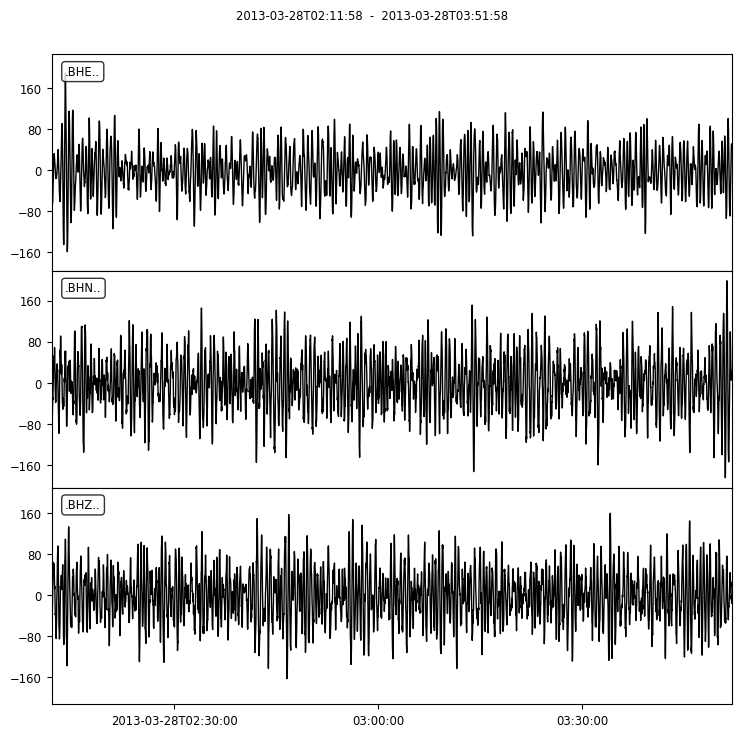

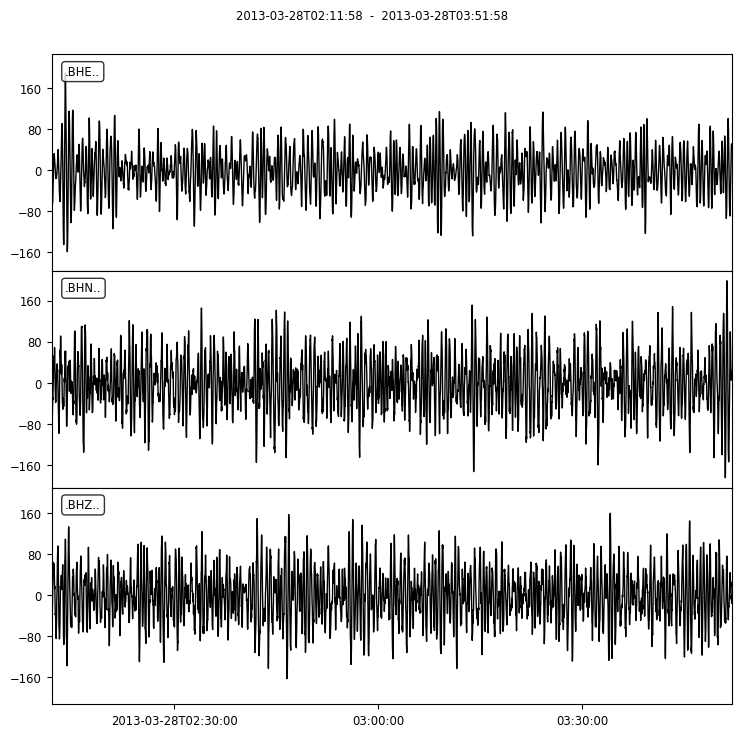

In [23]:


trace_BHE = Trace(
    data=single_event_trace[0],
    header={
        
        'starttime': start_time,
        'station' : "BHE"
    }
)

trace_BHN = Trace(
    data=single_event_trace[1],
    header={
        'starttime': start_time,
        'station' : "BHN"
    }
)
trace_BHZ = Trace(
    data=single_event_trace[2],
    header={
        'starttime': start_time,
        'station' : "BHZ"
    }
)

# Assemple into a Stream
stream = Stream([trace_BHE, trace_BHN, trace_BHZ])

# Plot it
stream.plot()
